## Optimization for Machine Learning SD-TSIA211

### Practical work on fixed point algorithms

Simon Queric \
Vincent Herfeld

In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, solve
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
from time import time

In [3]:
def load_data(file_name_matrix='tfidf_matrix.npz', file_name_feature_names='feature_names.npy',
          file_name_labels='train_labels.npy', samples_in_train_set=10000,
          samples_in_test_set=137562):
    # Recuperation des donnees
    TF_IDF_matrix = sp.load_npz(file_name_matrix)
    TF_IDF_feature_names = np.load(file_name_feature_names)
    train_labels = np.load(file_name_labels, allow_pickle=True)
    train_labels_numeric = ((train_labels == 'Oui') + 0)

    X = TF_IDF_matrix[:samples_in_train_set].toarray()
    y = train_labels_numeric[:samples_in_train_set] * 2 - 1

    X_test = TF_IDF_matrix[samples_in_train_set:samples_in_train_set+samples_in_test_set].toarray()
    y_test = train_labels_numeric[samples_in_train_set:samples_in_train_set+samples_in_test_set] * 2 - 1


    # Standardisation des données
    std_X = np.maximum(np.std(X, axis=0), 1e-7)
    X = X / std_X
    X_test = X_test / std_X

    n = X.shape[0]
    n_test = X_test.shape[0]
    m = X.shape[1]

    # Ajout d'une colonne de uns
    eX = np.hstack((np.ones((n,1)), X))
    eX_test = np.hstack((np.ones((n_test,1)), X_test))

    return eX, y, eX_test, y_test

In [4]:
X, y, eX_test, y_test = load_data(file_name_matrix='tfidf_matrix_97MB.npz', file_name_feature_names='feature_names_97MB.npy',file_name_labels='train_labels.npy', samples_in_train_set=10000,samples_in_test_set=137562)

In [5]:
n, p = np.shape(X)
print(n, p)

10000 576


In [6]:
X = np.insert(X, 0, np.ones(n), axis=1) 

In [7]:
n, p = np.shape(X)

def f1(w) :
    n = len(y)
    s = y*np.dot(X, w)
    return 1/n * np.sum(np.log(1+np.exp(-s))) + 1/(2*n) * np.dot(w[1:], w[1:])

## 3. Tikhonov regularization

### Question 3.1

#### Gradient of $f_1$ 

$\displaystyle \nabla f_1 = \left( \frac{\partial f_1}{\partial w_i}\right) = -\frac{1}{n}\sum_{k=1}^n{y_kx_{k, i}\sigma(-y_kx_k^Tw)} + \rho w_i \delta_{i\neq 0}$
where $\sigma(t) = \displaystyle\frac{e^{t}}{1+e^{t}} = \frac{1}{1+e^{-t}}$ is the sigmoid function.

#### Hessian matrix of $f_1$ 

$\displaystyle \frac{\partial^2 f_1}{\partial w_i \partial w_j} = \frac{1}{n}\sum_{k=1}^n{x_{k, i}x_{k, j}\frac{e^{-y_kx_k^Tw}}{(1+e^{-y_kx_k^Tw})^2}} + \rho \delta_{i=j, i\neq 0}$, hence :

$H = \displaystyle \frac{1}{n} \sum_{k=1}^n{x_kx_k^T\frac{e^{-y_kx_k^Tw}}{(1+e^{-y_kx_k^Tw})^2}} + \rho(I_p - E)$ where $(E_{i, j})_{1\leqslant i, j \leqslant p} = (\delta_{i, 1}\delta_{j, 1})_{1\leqslant i, j \leqslant p} \in \mathbb{R}^p$

$H$ is a sum of matrices semi-definite positive, hence $H$ is semi-definite positive. We deduce that $f_1$ is a convex function. 

### Question 3.2

In [8]:
def gradf1(w) :
    '''compute the gradient of f1'''
    p = len(w)
    n = len(y)
    s = y*np.dot(X, w)
    g = np.zeros(p)
    z = y*np.exp(-s)/(1+np.exp(-s)) 
    a = w.copy()
    a[0] = 0
    g = -1/n * np.dot(X.T, z) + 1/n * a
    return g   

In [9]:
def hessf1(w) :
    ''' compute the Hessian matrix of f1'''
    p = len(w)
    n = len(y)
    s = y*np.dot(X, w)
    I = np.eye(p)
    I[0, 0] = 0
    a = np.exp(-s)/(1+np.exp(-s))**2
    H = 0
    M = X * a[:, np.newaxis]
    H = 1/n*np.dot(X.T, M) + 1/n * I
    
    return H

We can check the corectness of our function <i> gradf1 </i> with the function check_grad from the library scipy.optimize :

In [10]:
w = np.zeros(p)
check_grad(f1, gradf1, w)

1.7954769915671704e-07

In [11]:
w0 = np.zeros(p)

In [12]:
f1(w0)

0.6931471805599453

Let's check the running time of our functions

In [13]:
start = time()
gradf1(w0)
end = time()
print(end-start, 's')

0.025030136108398438 s


In [14]:
np.linalg.norm(gradf1(w0))

1.502247420585552

In [15]:
start = time()
hessf1(w0)
end = time()
print(end-start, 's')

0.19264006614685059 s


In [16]:
hessf1(w0)

array([[0.25      , 0.25      , 0.05359961, ..., 0.06745536, 0.14326925,
        0.096354  ],
       [0.25      , 0.2501    , 0.05359961, ..., 0.06745536, 0.14326925,
        0.096354  ],
       [0.05359961, 0.05359961, 0.26159167, ..., 0.01879477, 0.03259928,
        0.02012643],
       ...,
       [0.06745536, 0.06745536, 0.01879477, ..., 0.2683009 , 0.0423312 ,
        0.02748576],
       [0.14326925, 0.14326925, 0.03259928, ..., 0.0423312 , 0.33220431,
        0.06168203],
       [0.096354  , 0.096354  , 0.02012643, ..., 0.02748576, 0.06168203,
        0.28723638]])

### Question 3.3

In [15]:
def NewtonsMethod(w0, eps) :
    w = w0.copy()
    g = gradf1(w)
    n = np.linalg.norm(g)
    l = [n]
    while n>=eps :
        w -= np.matmul(np.linalg.inv(hessf1(w)), g) 
        g = gradf1(w)
        n = np.linalg.norm(g)
        l.append(n)
    return w, l

In [16]:
w0 = np.zeros(p)

w, l = NewtonsMethod(w0,1e-10)

In [17]:
print('f1(e) =', f1(w0)) 
print('f1(w) =', f1(w))

f1(e) = 0.6931471805599453
f1(w) = 0.5680668879863778


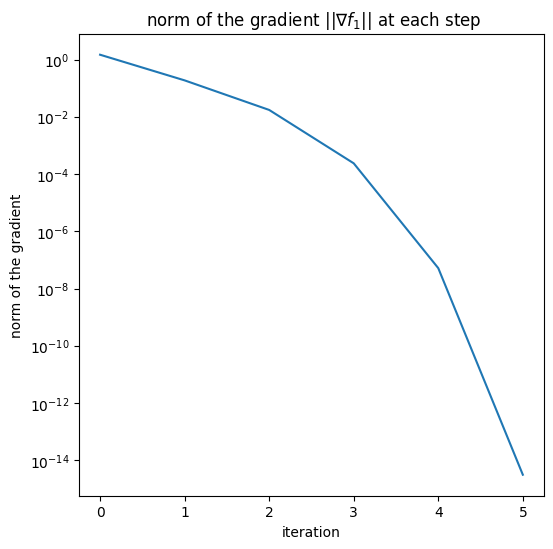

In [18]:
plt.figure(figsize=(6, 6))
plt.semilogy(l)
plt.xlabel('iteration')
plt.ylabel('norm of the gradient')
plt.title(' norm of the gradient $ \|| \\nabla f_1\||$ at each step')
plt.show()

In [19]:
w0 = np.ones(p)

In [20]:
w, l = NewtonsMethod(w0,1e-10)

/var/folders/c0/d3_lqdr53vs56db95whhzj280000gn/T/ipykernel_4884/4287560925.py:7: RuntimeWarning: overflow encountered in exp
  z = y*np.exp(-s)/(1+np.exp(-s))
/var/folders/c0/d3_lqdr53vs56db95whhzj280000gn/T/ipykernel_4884/4287560925.py:7: RuntimeWarning: invalid value encountered in divide
  z = y*np.exp(-s)/(1+np.exp(-s))


### Question 3.4

We perform a Armijo's line search with the classical choices of parameters : $a=0.5$, $b=2\gamma_{k-1}$ and $\beta = 1/2$ 

At each step we have to find the smallest integer $\ell$ such that $f_1(x^+(ab^{\ell})) \leqslant f_1(x_k) + \displaystyle \frac{1}{2} \langle \nabla f_1(x_k), x^+(ab^{\ell}) - x_k \rangle$

In [21]:
def linesearch(w0, eps) :
    w = w0.copy()
    g = gradf1(w)
    n = np.linalg.norm(g)
    norms = [n]
    a = 0.5
    b = 2
    while n>=eps :
        l = 0
        s = np.matmul(np.linalg.inv(hessf1(w)), g) 
        x = w - b*a**l * s
        while f1(x) > f1(w) + 1/2 * np.dot(g, x - w) :
            l+=1    
            x = w - b*a**l * s
        w -= b*a**l * s
        b = 2*b*a**l
        g = gradf1(w)
        n = np.linalg.norm(g)
        norms.append(n)
    return w, norms

In [22]:
w0 = np.ones(p)
w, norms = linesearch(w0,1e-10)

/var/folders/c0/d3_lqdr53vs56db95whhzj280000gn/T/ipykernel_4884/2467316492.py:6: RuntimeWarning: overflow encountered in exp
  return 1/n * np.sum(np.log(1+np.exp(-s))) + 1/(2*n) * np.dot(w[1:], w[1:])


In [23]:
print('f1(e) =', f1(w0)) 
print('f1(w) =', f1(w))

f1(e) = 63.330022271703484
f1(w) = 0.5680668879863778


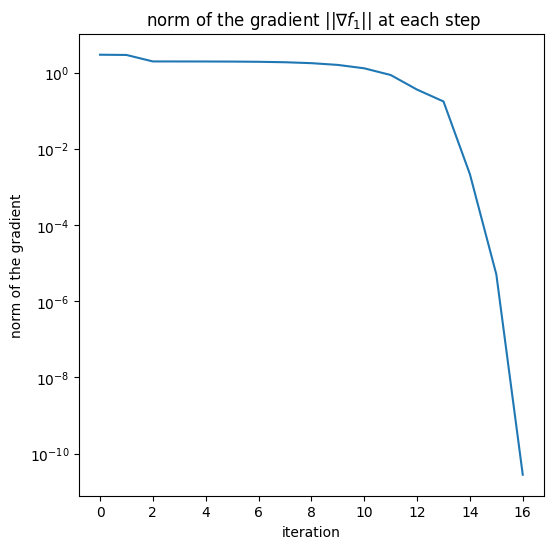

In [24]:
plt.figure(figsize=(6, 6))
plt.semilogy(norms)
plt.xlabel('iteration')
plt.ylabel('norm of the gradient')
plt.title(' norm of the gradient $ \|| \\nabla f_1\||$ at each step')
plt.show()

## 4. Regularization for a sparse model

### Question 4.1

We can't use Newton's method because the function $F_2$ isn't differentiable. 

### Question 4.2

We can write $F_2 = f_2 + g_2$ with $g_2 : x \mapsto  \rho \|x\|_1$

The formula for the proximal operator of $g_2$ is $ \displaystyle \text{prox}_{g_2}(x) = \text{argmin}_y\left\{g_2(y) + \frac{1}{2}\|y - x\|_2^2\right\} = \text{argmin}_y\left\{ \rho \|y\|_1 + \frac{1}{2} \|y - x\|_2^2\right\}$

We have $\text{prox}_{\gamma g_2}(x)_i = \begin{cases}
      0 & \text{if} \ |x_i| \leqslant \rho\gamma \\
      x_i-\rho\gamma & \text{if} \ x_i > \rho\gamma \\
      x_i+\rho\gamma & \text{if} \ x_i < -\rho\gamma \\
    \end{cases}$ for a step size $\gamma > 0$


We have : $\displaystyle \frac{\partial f_2}{\partial w_i} = -\frac{1}{n}\sum_{k=1}^n{y_kx_{k, i}\sigma(-y_kx_k^Tw)}$
où $\sigma(t) = \displaystyle\frac{e^{t}}{1+e^{t}} = \frac{1}{1+e^{-t}}$ est la fonction sigmoïde.


### Question 4.3

The proximal gradient method consists to calculate at each step : 

$ x_{k+1} = \text{prox}_{\gamma_k g_2}(x_k - \gamma_k \nabla f_2 (x_k)) $ with $\gamma_k = ba^{\ell}$ such that $f_2(x^+(ab^{\ell})) \leqslant f_2(x_k) + \displaystyle \frac{1}{2} \langle \nabla f_2(x_k), x^+(ab^{\ell}) - x_k \rangle$ and $x^+(\gamma) = \text{prox}_{\gamma g_2}(x_k - \gamma \nabla f_2(x_k)) $

The algorithm stop when the stopping test $\|x_{k+1}-x_k\|\leqslant \varepsilon$ is true for a fixed $\varepsilon$.

In [25]:
rho = 0.02

In [26]:
def f2(w) :
    n = len(y)
    s = y*np.dot(X, w)
    return 1/n * np.sum(np.log(1+np.exp(-s)))

In [27]:
def gradf2(w) :
    '''compute the gradient of f2'''
    p = len(w)
    n = len(y)
    s = y*np.dot(X, w)
    g = np.zeros(p)
    z = y*np.exp(-s)/(1+np.exp(-s)) 
    a = w.copy()
    a[0] = 0
    g = -1/n * np.dot(X.T, z) 
    return g   

In [28]:
def g2(w) :
    return 0.02 * np.sum(np.abs(w[1:]))

In [29]:
def F2(w):
    return f2(w)+g2(w)

In [30]:
def prox(w, gamma) : 
    ''' compute the proximal operator of \gamma g2'''
    p = len(w)
    prox = np.zeros(p)
    for i in range(p) :
        if w[i]>gamma*rho :
            prox[i] = w[i]-gamma*rho
        if w[i]<-gamma*rho :
            prox[i] = w[i]+gamma*rho
    return prox

In [31]:
def prox(w, gamma) : 
    ''' compute the proximal operator of \gamma g2'''
    p = len(w)
    prox = np.zeros(p)
    for i in range(p) :
            prox[i] = np.max(np.abs(w[i]) - rho*gamma, 0)*np.sign(w[i])
    
    return prox

In [32]:
def ProximalMethod(w0, eps) :
    w = w0.copy()
    g = gradf2(w)
    a = 0.5
    b = 1
    l = 0 
    x = prox(w- b*a**l * g, b*a**l)
    while f2(x) > f2(w) + 1/2 * np.dot(g, x - w) :
        l+=1    
        x = prox(w-b*a**l * g, b*a**l)
    b = 2*b*a**l
    g = gradf2(w)
     
    while np.linalg.norm(w-x) > eps :
        l = 0 
        w=x
        x = prox(w- b*a**l * g, b*a**l)
        while f2(x) > f2(w) + 1/2 * np.dot(g, x - w) :
            l+=1    
            x = prox(w- b*a**l * g, b*a**l)
        b = 2*b*a**l
        g = gradf2(w)
    
    return w

We can test our proximal gradient method on some points : 

In [33]:
w0 = np.zeros(p)
print('F_2(w0) = {:.4f}'.format(F2(w0)))
w = ProximalMethod(w0,1e-10)
print('F_2(w) = {:.4f}'.format(F2(w)))

F_2(w0) = 0.6931
F_2(w) = 0.6635


In [38]:
w0 = np.ones(p)
print('F_2(w0) = {:.4f}'.format(F2(w0)))
w = ProximalMethod(w0,1e-21)
print('F_2(w) = {:.4f}'.format(F2(w)))

F_2(w0) = 74.8212
F_2(w) = 0.8222
